# Recommender Systems & Collaborative Filtering
--------
## Contents
---------

__[1. Introduction](#first-bullet)__

__[2. Preprocessing & Basic Statistics](#second-bullet)__

__[3. User-User Collaborative Filtering](#third-bullet)__

__[4. Next Steps](#fourth-bullet)__


--------
## Introduction <a class="anchor" id="first-bullet"></a>
---------

Recommender systems are one of the most important applications of data science across the consumer-facing technology industry.  They are used almost everywhere; examples are 'Amazon’s Recommended Items', Internet Radio stations, and suggested videos on Netflix.  There are two general approaches to recommender systems:

1. <a href="https://en.wikipedia.org/wiki/Collaborative_filtering">Collaborative filtering</a>

2. <a href="https://en.wikipedia.org/wiki/Recommender_system#Content-based_filtering">Content-based filtering</a>

Collaborative filtering is a method of recommending products to customers by using their past behaviors or product ratings, as well as similar decisions by other customers to predict which items might be appealing to the original customers. Content-based filtering suggests products to customers by using the characteristics of an item they have selected in the past in order to recommend additional items with similar properties.  There are advantages and disadvantages to both of these methods.  

Collaborative filtering suffers from the cold start problem, meaning it requires a certain threshold of user input in order to make any recommendations. Content-based filtering, on the other hand, only requires one data point--for example, one item that a specific user has purchased--in order to produce suggestions. However, content-based filtering is limited in scope and in the relevance of its results, since it can only recommend products that are similar to the original product selected. Collaborative filtering can overcome this limitation by suggesting products not necessarily similar to previous products that user has selected, but that similar users have found appealing. Because of this ability to accurately recommend complex items without needing to understand the qualities of the items themselves, collaborative filtering is the more widely used method, and thus the focus of this blog post. Collaborative filtering is also much more popular for web-based recommendations where the data is sparse, i.e., where there is a limited number of reviews by each user or for a particular product.

---------
## Collaborative Filtering
---------

As mentioned previously, in collaborative filtering we do not need to know much about the products or the customers.  We just need to know need to know how many unique products and customers there as well as how the customers rated the products.  This information is stored in a user-item table, where the ratings are the entries in the table. An example of a user-item table can be seen below,

![table](images/table.jpg)


The ratings matrix is another representation of the user-item table where each user and item have been assigned an unique integer value. The general rating matrix $\textbf{R}$ is in $ R^{n_{u} \times n_{i}}$ where $n_{u}$ is the number of users and $n_{i}$ is the number of items.  Let $R_{i,j}$ entry correspoing to the $i$-th row and $j$-th column of the matrix $\textbf{R}$. $R_{i,j}$ is then the rating by user $i$ on item $j$.  The entries that have missing values in the matrix will be filled in with 0's.

In collaborative filtering we typically focus on two tasks. The first is,

**1.) Given a user and an item, what is the user’s likely preference for the item? **

This can also be viewed as filling in the missing values in the table above.  The second task is,

**2.) Recommend a list of $n$ items for a user based off of information we can obtain from the user-item table.  **

Within collaborative filtering there are two different modeling perspectives to answering the first question: 

-  **Memory based**: This approach uses customer rating data to compute the similarity between customers or items and make recommendations. This was an early approach used in many commercial systems and has the benefit of being easy to explain. However, it doesnt scale well with sparse data as we will discuss later.  


-  **Model based**: This approach to collaborative filtering scales much better with sparse data and can uncover hidden or latent features in our dataset.  One draw back to this method is that it can be hard to explain/justitfy the predictions.   

In this blog post I'll talk I'll go user-user collaborative filtering to predict how a given user will rate an item for now and look into other methods later on. Let's jump into the code...

---------
## Preprocessing & Basic Statistics <a class="anchor" id="second-bullet"></a>
---------
First let's load some of the basic libraries,

In [1]:
import pandas as pd
import numpy as np
from scipy.sparse import csc_matrix
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

The data we will use comes from <a href="https:amazon.com">Amazon</a> and can be found <a href="http://jmcauley.ucsd.edu/data/amazon/">here</a>.  I chose the Amazon Instant Video 5 core file. The 5 core implies that each video/item has atleast 5 ratings and each users has rated atleast 5 videos/items.  Unzipping the file results in a json file that I was not  able to read using the Pandas <a href="http://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_json.html">read_json</a> function. So I read in the contents of the file using the function below:

In [2]:
from readFunctions import *
df = openFile('reviews_Amazon_Instant_Video_5.json.gz')

We can get the basic info on the dataset, including the number of reviews and the column descriptions using the Pandas <a href="http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.info.html">info</a> function,

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37126 entries, 0 to 37125
Data columns (total 10 columns):
Unnamed: 0        37126 non-null int64
reviewerID        37126 non-null object
asin              37126 non-null object
reviewerName      36797 non-null object
helpful           37126 non-null object
unixReviewTime    37126 non-null int64
reviewText        37126 non-null object
overall           37126 non-null float64
reviewTime        37126 non-null object
summary           37126 non-null object
dtypes: float64(1), int64(2), object(7)
memory usage: 2.8+ MB


We can also get a peek at the data by looking at the first few rows,

In [4]:
df.head(2)

,Unnamed: 0,reviewerID,asin,reviewerName,helpful,unixReviewTime,reviewText,overall,reviewTime,summary
0,0,A11N155CW1UV02,B000H00VBQ,AdrianaM,"[0, 0]",1399075200,I had big expectations because I love English ...,2.0,"05 3, 2014",A little bit boring for me
1,1,A3BC8O2KCL29V2,B000H00VBQ,Carol T,"[0, 0]",1346630400,I highly recommend this series. It is a must f...,5.0,"09 3, 2012",Excellent Grown Up TV


The <code>asin</code> value for each review is the actual "id" of the product or video on Amazon. If you copy and paste this id/code into the search on <a href="https://amazon.com">amazon.com</a>, then the product list will come up!


Now, let's start out by get some basic statistics on the ratings of Amazon instant videos in the data,

In [5]:
print "Mean rating : " + str(df['overall'].mean())
print "Mean rating standard deviation: " + str(df['overall'].std())

Mean rating : 4.20952970964
Mean rating standard deviation: 1.11854966688


The average rating over all videos is 4.2 out of 5.  We can see the overall distribution of reviews below,

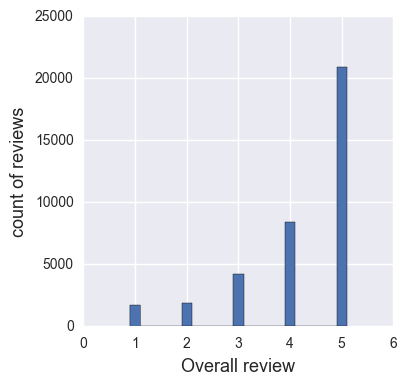

In [6]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
ax.hist(df['overall'], bins=[0.9, 1.1, 1.9, 2.1, 2.9, 3.1, 3.9, 4.1, 4.9, 5.1])
ax.set_xlabel('Overall review', fontsize=13)
ax.set_ylabel('count of reviews', fontsize=13)
#ax.title('Distribution of reviews', fontsize=15)

We can also get the number of reviewers by counting the unique values of <code>reviewerID</code> and the product by counting the unique values of <code>asin</code>:

In [9]:
num_users = len(df['reviewerID'].unique())
num_items = len(df['asin'].unique())

print "Number of reviewers: " + str(num_users)
print "Number of products : " + str(num_items)
print "Number of ratings  :" + str(len(df))

Number of reviewers: 5130
Number of products : 1685
Number of ratings  :37126


We can also find out the average number of ratings per reviewer using the  <a href="http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html">groupby</a> function with <code>reviewerID</code> and then counting the number of product reviews,

In [10]:
avg_num_reviews = df.groupby('reviewerID')['asin'].count()
print "Avg Number of ratings per reviewer : " + str(avg_num_reviews.mean())

Avg Number of ratings per reviewer : 7.23703703704


We can also get the distribution of the mean rating of each reviewer,

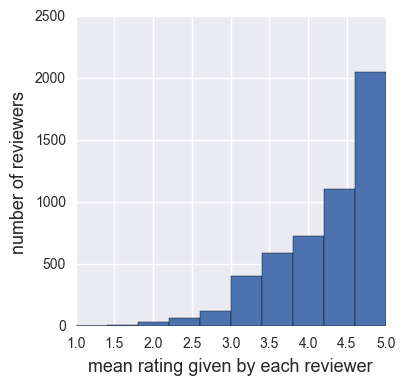

In [11]:
mean_rating_of_user = df.groupby('reviewerID').apply(
                                                lambda x: 
                                                x['overall'].mean())

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
ax.hist(mean_rating_of_user)
ax.set_xlabel('mean rating given by each reviewer', fontsize=13)
ax.set_ylabel('number of reviewers', fontsize=13)

We could keep exploring the data to get more insights, but one of the appealing aspects about collaborative filtering is that we don't actually have to know much about the products or customters' preferences in order to make recommedations. Instead, all we need to need is the user-item table or ratings matrix and this is what we will discuss next.

Now we want to make a ratings matrix out of our DataFrame to represent the user-item table.  In order to do this we have to assign each video and reviewer an unique index that will correspond to a row and a column in the matrix respectively. We do this by turning each <a href="http://pandas.pydata.org/pandas-docs/stable/categorical.html">categorical</a> data-types:

In [3]:
# turn each reviewer and product into categorical data,
df['reviewerID'] = df['reviewerID'].astype("category")
df['asin'] = df['asin'].astype("category")

We then create a matrix of all the videos/reviewer/ratings tripples for the training set.  We format the matrix such that each row is a unique item/video and each column is a unique reviewer.  The value of each matrix $R_{i,j}$ will then be the rating that a reviewer $j$ gave on video $i$:

In [4]:
reviews = csc_matrix((df['overall'].astype(float), 
                    (df['reviewerID'].cat.codes,
                     df['asin'].cat.codes)))
reviews.shape

(5130, 1685)

Since most reviewers/customers only rate a few videos there will be many entries in this matrix with missing values and by default will have 0 value.  Since there will be so few non-zero values this matrix will be pretty sparse and hence we should use a sparse matrix to store it. A sparse matrix only stores the non-zero entries and reduces memory usage.  However, our data is not that large and dense matrices can be a little easier to work with so I will convert this matrix into a dense one:

In [5]:
ratings_matrix = reviews.toarray()

We can see then sparsity of this matrix,

In [15]:
sparsity = float(len(ratings_matrix.nonzero()[0]))
sparsity /= (ratings_matrix.shape[0] * ratings_matrix.shape[1])
sparsity *= 100
print 'Sparsity: {:4.2f}%'.format(sparsity)

Sparsity: 0.43%


The main idea of collaborative filtering is we want to predict how each user will feel about a product, that is, to find the missing values in the matrix. One idea is to fill in the missing values with the mean rating of all users and on all products. The overall mean can be obtained by,

In [38]:
mean_rating = df['overall'].mean()

We can get then root mean square error in this prediction by computing by getting the non-zero rating values in the matrices using the above method and taking the square of the difference in these values from the <code>mean_rating</code>,

In [46]:
base_rmse = np.sqrt(pow(df['overall']-mean_rating, 2).mean())
print "RMSE = " + str(base_rmse)

RMSE = 1.11853460254


This is a pretty naive approach, but it will give us a baseline to compare the other methods we use.  Our goal will be to find collaborative filtering methods that result in smaller errors than above and we will start with user-user collaborative filtering.

--------
##  User-User Collaborative Filtering <a class="anchor" id="third-bullet"></a>
--------

The basic idea of user-user collaborative filtering is to predict a customer, $u$'s rating of a product, $i$, by finding customers that are similar to $u$ and use their rating of product $i$ to estimate how customer $u$ would rate it.  The way we measure how similar customers are is through a function called the <a href="https://en.wikipedia.org/wiki/Cosine_similarity">cosine similarity</a> function.  The cosine similarity between user $u$ and user $v$ is the normalized dot product of their row vectors, ($\textbf{r}_{u}$ and $\textbf{r}_{v}$ respectively) in the rating matrix $\textbf{R}$,

$$ s(u,v) = \frac{\textbf{r}_{u} \cdot \textbf{r}_{v}}{ \Vert \textbf{r}_{u} \Vert \Vert \textbf{r}_{v} \Vert} $$

As mentioned previously, unknown ratings are considered to be 0; this causes them to effectively drop out of the numerator. To generate predictions for user $u$ on product $i$ from the cosine similarity function we then use a weighted average of some set of similar users ($N$) and thoses customers ratings of product $i$, 

$$ p_{u,i} = \bar{r}_{u} + \frac{\sum_{v \in N} s(u,v) (R_{v,i} - \bar{r}_{v})}{\sum_{v \in N} \vert s(u,v) \vert} $$

$\bar{r}_{v}$ is the mean rating of all customers on all products and  $\bar{r}_{u}$ is the mean rating of user $u$ on all products.  

In order to compute the cosine similarity function between users we import the <a href="http://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html">cosine_similarity</a> function from the <a href="http://scikit-learn.org/stable/">scikit-learn</a> library:

In [18]:
from sklearn.metrics.pairwise import cosine_similarity

We end up pre-computing all the cosine similarities between users and make a similarity matrix out it in the function calls below.  The first user-user collaborative filtering algorithm is below. We first compare each users similarity to *all* other users and make recommendations.  Notice we dont break up our data into training and testing sets.  Instead, we loop over all the users and all the products and treat each product for each user as a missing value and then predict its value. We then get the error between the predicted rating and the actual rating.

The function below will then return the root mean square error in this algorithm over all users.

** NOTE: This method is not meant for speed, it is not ideal for caching and memory usage.** 

In [23]:
def User_User_CF(reviews):
    """
    Obtains the RMSE error in the user-user collaborative 
    filtering algorithms using all the similar users.
    
    :param: reviews (numpy.ndarray) : The dense user-item matrix.
    
    :returns: RMSE of predictions
    :rvalue: float
    """
    
    # Get the user-user similarity matrix
    user_user_similarity = cosine_similarity(reviews)
    
    sqdiffs = 0
    num_preds = 0

    # to protect against divide by zero issues
    eps = 1e-6

    cnt_no_sims = 0
    # loop over the users
    for user_i, u in enumerate(reviews):
        
        # products user HAS rated
        i_rated = np.where(u>0)[0]
    
        # Get the average rating for this user
        user_avg =  i_rated.mean()
        
        # loop over all the products that each user reviewed
        # Note: these are all the non-zero entries in the row
        for i_product in i_rated:
        
            # Get all the users (indices) that
            # have also reviewed this product.
            # Note: This also includes the user of interest!
            i_has_rated = np.where(reviews[:, i_product])[0]
        
            # remove the user (indices) of interest 
            # from this column
            i_remove = np.argmin(abs(i_has_rated - user_i))
            i_others_have_rated = np.delete(i_has_rated, i_remove)
        
            # Get the ratings for product by the similar users,
            ratings = reviews[i_others_have_rated, 
                              i_product]
                    
            ratings -= user_avg
               
            # get the cosine similarity between the users
            # and other users.
            similarities = user_user_similarity[user_i,
                                                i_others_have_rated]
            
            # denominator of user_i's produdct prediction
            norm = np.sum(similarities)
            if norm==0:
                cnt_no_sims += 1
                norm = eps
            
            # prediction of user u on product i: p_{u,i}
            predicted_rating = user_avg + np.sum(np.multiply(
                                            ratings.T,
                                            similarities))/norm
            
            # actual rating by user u on product i
            actual_rating = reviews[user_i, i_product]
            
        # get the L2 difference in predicted and actual
        # rating for the user
        sqdiffs += pow(predicted_rating - actual_rating, 2.0)
        num_preds+=1
    
    # get the average of all the predictions
    rmse_cossim = np.sqrt(sqdiffs/num_preds)
    return rmse_cossim

Let's see how well the algorithm performs by computing the RMSE of the predicted user ratings,

In [44]:
user_all_rmse = User_User_CF(ratings_matrix)
print user_all_rmse

1.03894378624


This is definitely an improvement in the prediction error compared to just using the mean ratings as an approximate for unknown customer ratings! 

We might be able to improve the runtime of our algorithm if we reduce the number of customers we use to generate recommendations.  If a customer is disimilar to our customer of interest, not including them in our computations may not effect the accuracy of prediction, but reduce the number of computations we have to do. The next function performs user-user collaborative filtering just as above, but this time only uses the top $N$ most similar customers to predict the customer of interest's missing rating:

In [32]:
def User_User_CF_TopN(reviews, N):
    """
    Obtains the RMSE error in the user-user collaborative 
    filtering algorithms using the top N most similar users.
    
    :param: reviews (numpy.ndarray) : The dense user-item matrix.
    :param: N (int) : The number of the most similar users.
    
    :returns: RMSE of predictions
    :rvalue: float
    """
    
    # Get the user-user similarity matrix
    user_user_similarity = cosine_similarity(reviews)
 
    sqdiffs = 0
    num_preds = 0

    # to protect against divide by zero issues
    eps = 1e-6

    cnt_no_sims = 0
    # loop over the users
    for user_i, u in enumerate(reviews):
        
        # products user HAS rated
        i_rated = np.where(u>0)[0]
    
        # Get the average rating for this user
        user_avg = i_rated.mean()
        
        # loop over all the products that each user reviewed
        # Note: these are all the non-zero entries in the row
        for i_product in i_rated:
        
            # Get all the users (indices) that
            # have also reviewed this product.
            # Note: This also includes the user of interest!
            i_has_rated = np.where(reviews[:, i_product]>0)[0]
        
            # remove the user (indices) of interest 
            # from this column
            i_remove = np.argmin(abs(i_has_rated - user_i))
            i_others_have_rated = np.delete(i_has_rated, i_remove)
        
            # Get the ratings for product by the similar users,
            ratings = reviews[i_others_have_rated, 
                              i_product]
                    
            ratings -= user_avg
               
            # get the cosine similarity between the users
            # and other users.
            sims = user_user_similarity[user_i,
                                        i_others_have_rated]
            
            #choose top N most similar users
            most_similar_users = sims[np.argsort(sims*-1)][:N]
            most_similar_ratings = ratings[np.argsort(sims*-1)][:N]
            
            # denominator of user_i's produdct prediction
            norm = np.sum(most_similar_users)
            if norm==0:
                cnt_no_sims += 1
                norm = eps
            
            # prediction of user u on product i: p_{u,i}
            predicted_rating = user_avg + np.sum(np.multiply(
                                            most_similar_ratings.T,
                                            most_similar_users))/norm
            
            # actual rating by user u on product i
            actual_rating = reviews[user_i, i_product]
        
        # get the L2 difference in predicted and actual
        # rating for the user
        sqdiffs += pow(predicted_rating - actual_rating, 2.0)
        num_preds+=1
    
    # get the average of all the predictions
    rmse_cossim = np.sqrt(sqdiffs/num_preds)
    return rmse_cossim

We can loop through a number different choices for $N$ (the number of most similar customters) and see how this number affects the error in our user-user collabortive filtering algorithm:

In [53]:
N_users = [1,2,3,4,5,10,25,50]
top_N = [User_User_CF_TopN(ratings_matrix, i) for i in N_users]

We can now compare the RMSE in the different recommendation methods:

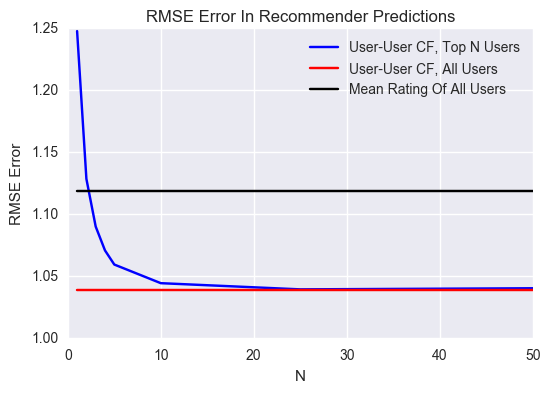

In [55]:
# make constant vectors
user_all = []
mean_all = []
for i in range(len(N_users)):
    user_all.append(user_all_rmse)
    mean_all.append(base_rmse)
    
plt.plot(N_users, top_N, 'b', label = 'User-User CF, Top N Users')
plt.plot(N_users, user_all, 'r', label = 'User-User CF, All Users')
plt.plot(N_users, mean_all, 'k', label = 'Mean Rating Of All Users')
plt.xlabel('N')
plt.ylabel('RMSE Error')
plt.legend()
plt.title('RMSE Error In Recommender Predictions')

We can see that after aboud 25 users there isn't much improvement in predictive power of collaborative filtering.

--------
## Next Steps... <a class="anchor" id="fourth-bullet"></a>
------

User-User collaborative filtering while definitely an improvement over using the mean rating as predictor has some serious limitations.  First of all it does not scale well as the number of users grows. This is because searching for similar users will take longer as the list of users grows. Another method which scales better with a larger user base is item-item collaborative filtering, which is incredibly similar to user-user collaborative filtering.  An even better method is to use matrix-factorization in model based collaborative filtering. I'll be updating this post soon and go into the details of using another method.